In [35]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage.feature import canny
from collections import defaultdict
from PIL import Image
from skimage.color import rgba2rgb, rgb2gray
from skimage.feature import local_binary_pattern
from itertools import combinations
from shapely.geometry import box
from skimage.measure import shannon_entropy
import cv2
from shapely.geometry.polygon import Polygon

matplotlib.rcParams['font.family'] = 'Times New Roman'

In [36]:
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()

## Cantidad de fotos por set

In [37]:
directorio = './images'

In [38]:
cantidad_fotos = 0

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        cantidad_fotos += 1

print(f"La carpeta '{directorio}' contiene {cantidad_fotos} fotos.")

La carpeta './images' contiene 2000 fotos.


In [39]:
fotos_por_set = defaultdict(int)

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        numero_set = filename.split('_')[0]
        fotos_por_set[numero_set] += 1

# print("Frecuencia de fotos por set:")
# for numero_set, cantidad in fotos_por_set.items():
#     print(f"Set {numero_set}: {cantidad} fotos")

In [40]:
df = pd.read_csv('layoutsWithTags.csv')
numeros_de_sets_csv = df['layout_id'].unique()

def verificar_coincidencia(numero_set_csv):
    return str(numero_set_csv) in fotos_por_set

df['coincidencia'] = df['layout_id'].apply(verificar_coincidencia)
df_coincidentes = df[df['coincidencia']]

df_coincidentes.to_csv('layoutsWithTags.csv', index=False)

print(f"Se han guardado {len(df_coincidentes)} casos coincidentes en 'layoutsWithTags_coincidentes.csv'.")

Se han guardado 100 casos coincidentes en 'layoutsWithTags_coincidentes.csv'.


## Etiquetas

In [41]:
sin_etiquetas = df['relevant (new) tags'].isnull().sum()
fotos_sin_etiquetas = sin_etiquetas * 20

print(f"Total de filas sin etiquetas: {sin_etiquetas}")
print(f"Total de fotos sin etiquetas: {fotos_sin_etiquetas}")

Total de filas sin etiquetas: 0
Total de fotos sin etiquetas: 0


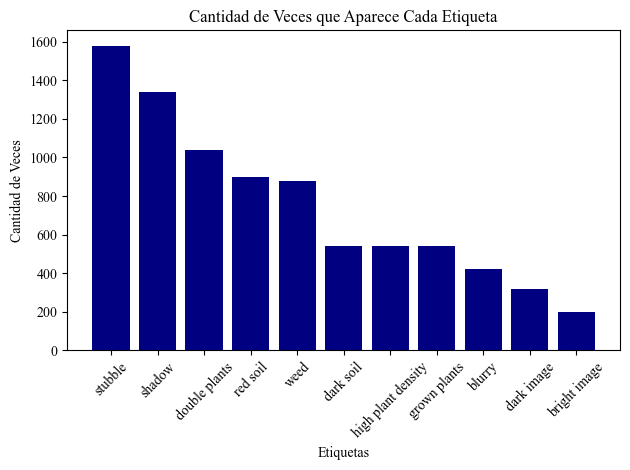

In [42]:
etiquetas_claves = {
    'dark soil': 1,
    'red soil': 2,
    'high plant density': 3,
    'shadow': 4,
    'stubble': 5,
    'weed': 6,
    'blurry': 7,
    'dark image': 8,
    'bright image': 9,
    'grown plants': 10,
    'double plants': 11
}

numeros = df['relevant (new) tags'].str.split(',')

todos_los_numeros = []
for sublist in numeros.dropna():
    for numero in sublist:
        if numero.strip():  # Ignorar valores vacíos
            todos_los_numeros.append(int(numero))

conteo_numeros = pd.Series(todos_los_numeros).value_counts()

conteo_numeros = conteo_numeros.sort_values(ascending=False)

etiquetas = [list(etiquetas_claves.keys())[list(etiquetas_claves.values()).index(num)] for num in conteo_numeros.index]

plt.bar(etiquetas, (conteo_numeros.values*20), color='navy')
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad de Veces')
plt.title('Cantidad de Veces que Aparece Cada Etiqueta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
data = json.loads(json_data)

width_list = []
height_list = []

for item in data:
    for slot in item['item']['slots']:
        width_list.append(slot['width'])
        height_list.append(slot['height'])

# print("Width List:", width_list)
# print("Height List:", height_list)

# Ancho y Alto de imagenes

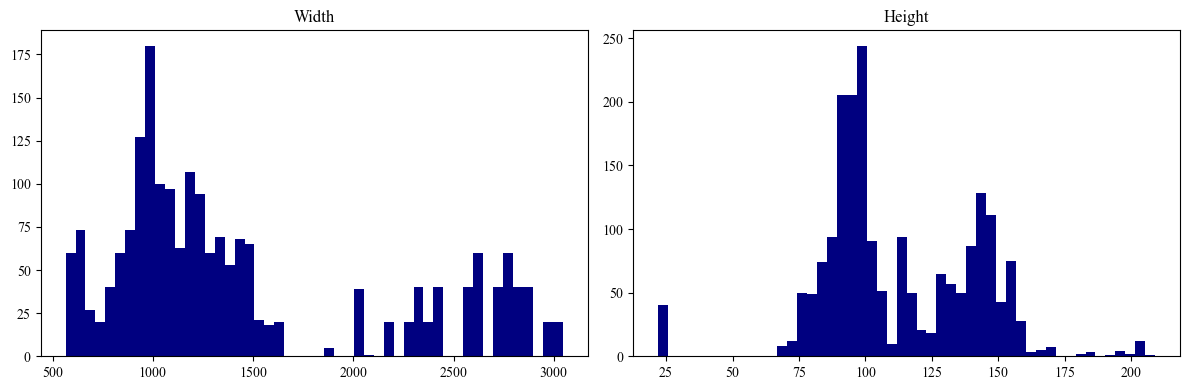

In [44]:
# plot histogram of width and height
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(width_list, bins=50, color='navy')
plt.title('Width')
plt.subplot(1, 2, 2)
plt.hist(height_list, bins=50, color='navy')
plt.title('Height')
plt.tight_layout()
plt.show()

In [45]:
def dibujar_bounding_box_extended(image, bounding_box, color, extension):
    x, y, w, h = bounding_box
    x_min = max(0, x - extension)
    y_min = max(0, y - extension)
    x_max = min(image.shape[1], x + w + extension)
    y_max = min(image.shape[0], y + h + extension)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
    
fotos_fuera_limites = []

for elemento in data:
    image_name = elemento['item']['name']

    slots = elemento.get('item', {}).get('slots', [])
    annotations = elemento.get('annotations', [])
    imprimir_imagen = False
    
    for annotation in annotations:
        bounding_box = [
            int(annotation['bounding_box']['x']),
            int(annotation['bounding_box']['y']),
            int(annotation['bounding_box']['w']),
            int(annotation['bounding_box']['h'])
        ]

        x_min, y_min, x_max, y_max = bounding_box
        if (x_max < 0 or y_max < 0 or x_min > slots[0]['width'] or y_min > slots[0]['height']):
            imprimir_imagen = True
            break 
       
    if imprimir_imagen:
        print("Nombre de la imagen:", image_name)  

Nombre de la imagen: 53975_38-5-1-1.png


# Datos generales

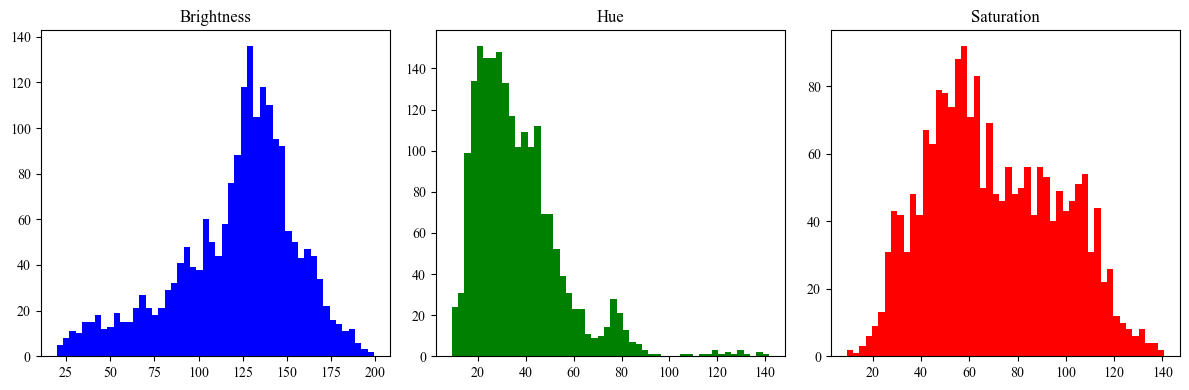

In [46]:
def extract_features(image):
    hsv_image = image.convert('HSV')
    h, s, v = hsv_image.split()
    brightness = np.mean(np.array(v))
    hue = np.mean(np.array(h))
    saturation = np.mean(np.array(s))
    
    return brightness, hue, saturation

def analyze_images(folder_path):
    brightness_values = []
    hue_values = []
    saturation_values = []
    
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = Image.open(image_path)
            brightness, hue, saturation = extract_features(image)
            brightness_values.append(brightness)
            hue_values.append(hue)
            saturation_values.append(saturation)
    
    return brightness_values, hue_values, saturation_values

if __name__ == "__main__":
    folder_path = "images"
    
    brightness_values, hue_values, saturation_values = analyze_images(folder_path)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(brightness_values, bins=50, color='b')
    plt.title('Brightness')
    plt.subplot(1, 3, 2)
    plt.hist(hue_values, bins=50, color='g')
    plt.title('Hue')
    plt.subplot(1, 3, 3)
    plt.hist(saturation_values, bins=50, color='r')
    plt.title('Saturation')
    plt.tight_layout()
    plt.show()

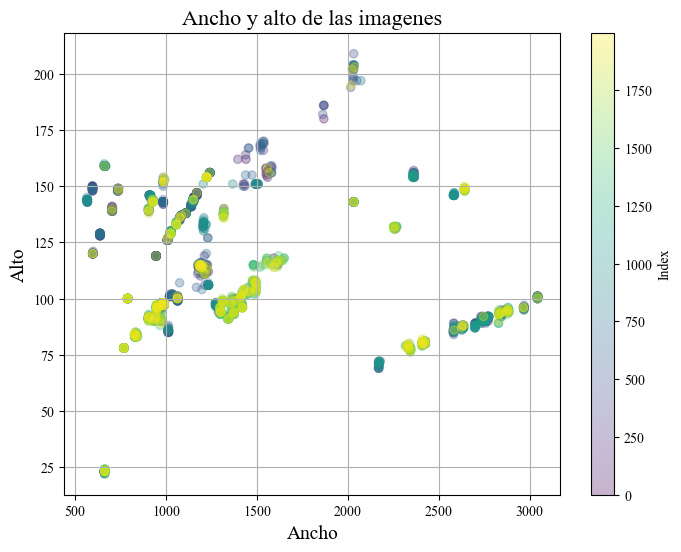

In [47]:
colors = range(len(width_list))
plt.figure(figsize=(8, 6))
plt.scatter(width_list, height_list, c=colors, cmap='viridis', alpha=0.3)
plt.colorbar(label='Index')
plt.title('Ancho y alto de las imagenes', fontsize=16)
plt.xlabel('Ancho', fontsize=14)
plt.ylabel('Alto', fontsize=14)
plt.grid(True)
plt.show()

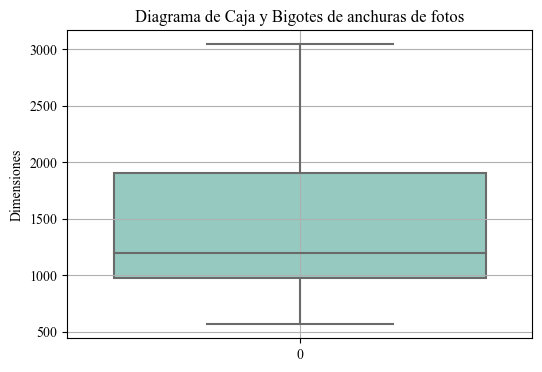

In [48]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=width_list, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de anchuras de fotos')
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

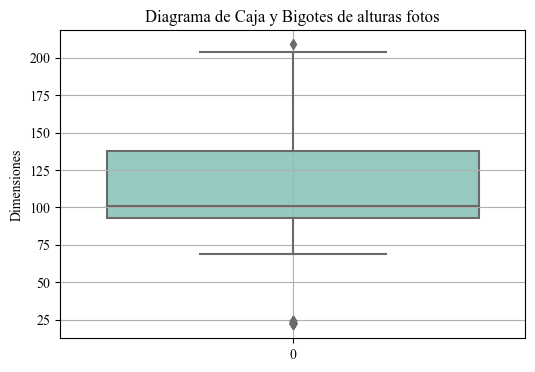

In [49]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=height_list, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de alturas fotos')
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

# Bounding Boxes

In [50]:
bounding_box_widths = []
bounding_box_heights = []
bounding_box_counts = []
category_counts = {}

for item in data:
    annotations = item.get('annotations', [])
    bounding_box_counts.append(len(annotations))  # Cantidad de bounding boxes por imagen
    for annotation in annotations:
        bounding_box = annotation.get('bounding_box', {})
        bounding_box_widths.append(bounding_box.get('w', 0))
        bounding_box_heights.append(bounding_box.get('h', 0))
        category = annotation.get('name', 'Unknown')
        category_counts[category] = category_counts.get(category, 0) + 1

In [51]:
# sum all the bounding boxes

total_bounding_boxes = sum(bounding_box_counts)
print(f"Total de bounding boxes: {total_bounding_boxes}")

Total de bounding boxes: 51276


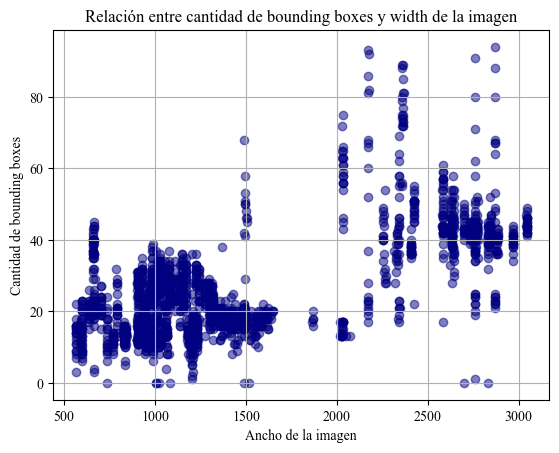

Coeficiente de correlación de Pearson: 0.6693937583744268


In [52]:
plt.scatter(width_list, bounding_box_counts, color='navy', alpha=0.5)
plt.title('Relación entre cantidad de bounding boxes y width de la imagen')
plt.xlabel('Ancho de la imagen')
plt.ylabel('Cantidad de bounding boxes')
plt.grid(True)
plt.show()

correlation = np.corrcoef(width_list, bounding_box_counts)[0, 1]
print("Coeficiente de correlación de Pearson:", correlation)

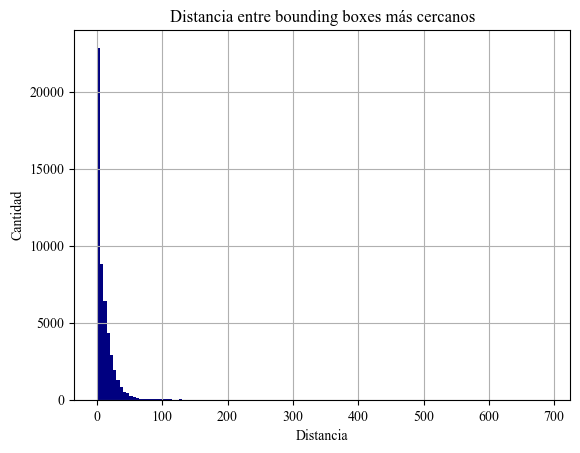

In [53]:
distance_between_bounding_boxes = []
for item in data:
    annotations = item.get('annotations', [])
    if len(annotations) < 2:
        continue  
    for i in range(len(annotations)):
        box_a = annotations[i].get('bounding_box', {})
        x1, y1, w1, h1 = box_a.get('x', 0), box_a.get('y', 0), box_a.get('w', 0), box_a.get('h', 0)
        box1 = box(x1, y1, x1 + w1, y1 + h1)
        min_distance = float('inf')
        for j in range(len(annotations)):
            if i != j:
                box_b = annotations[j].get('bounding_box', {})
                x2, y2, w2, h2 = box_b.get('x', 0), box_b.get('y', 0), box_b.get('w', 0), box_b.get('h', 0)
                box2 = box(x2, y2, x2 + w2, y2 + h2)
                distance = box1.distance(box2)
                min_distance = min(min_distance, distance)
        distance_between_bounding_boxes.append(min_distance)

plt.hist(distance_between_bounding_boxes, bins=np.arange(0, int(max(distance_between_bounding_boxes)) + 5, 5), color='navy')
plt.title('Distancia entre bounding boxes más cercanos')
plt.xlabel('Distancia')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

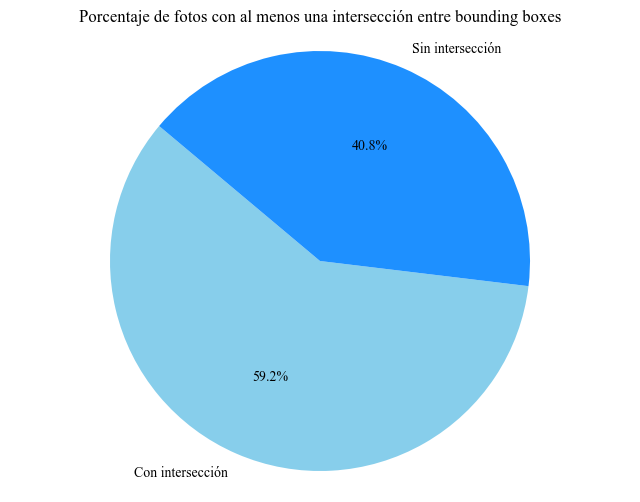

In [54]:
fotos_con_interseccion = 0
total_fotos = len(data)

for item in data:
    annotations = item.get('annotations', [])
    if len(annotations) < 2:
        continue  
    for a, b in combinations(annotations, 2):
        box_a = a.get('bounding_box', {})
        box_b = b.get('bounding_box', {})
        x1a, y1a, w1a, h1a = box_a.get('x', 0), box_a.get('y', 0), box_a.get('w', 0), box_a.get('h', 0)
        x1b, y1b, w1b, h1b = box_b.get('x', 0), box_b.get('y', 0), box_b.get('w', 0), box_b.get('h', 0)
        box1 = box(x1a, y1a, x1a + w1a, y1a + h1a)
        box2 = box(x1b, y1b, x1b + w1b, y1b + h1b)
        intersection = box1.intersection(box2)
        if intersection.area > 0:
            fotos_con_interseccion += 1
            break  

fotos_sin_interseccion = total_fotos - fotos_con_interseccion

sizes = [fotos_con_interseccion, fotos_sin_interseccion]
labels = ['Con intersección', 'Sin intersección']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'dodgerblue'])
plt.title('Porcentaje de fotos con al menos una intersección entre bounding boxes')
plt.axis('equal') 
plt.show()

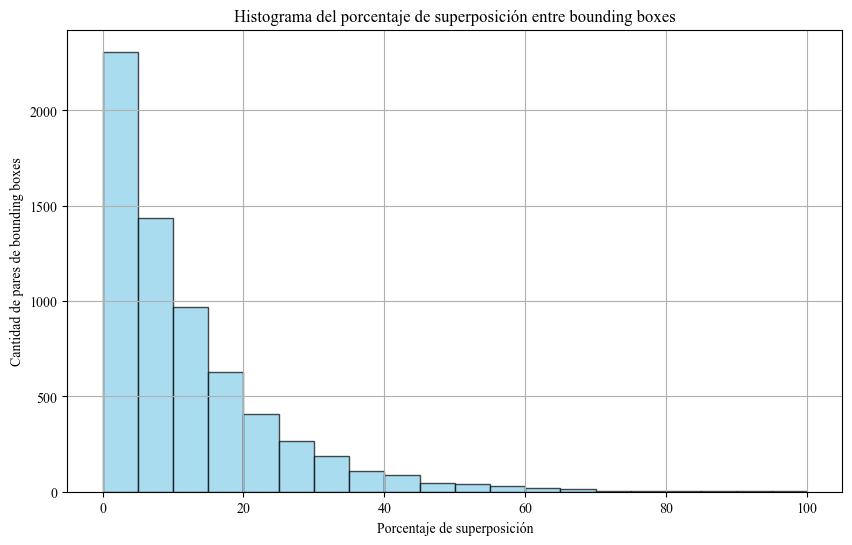

In [55]:
porcentajes_superposicion = []

for item in data:
    annotations = item.get('annotations', [])
    if len(annotations) < 2:
        continue  
    for a, b in combinations(annotations, 2):
        box_a = a.get('bounding_box', {})
        box_b = b.get('bounding_box', {})
        x1a, y1a, w1a, h1a = box_a.get('x', 0), box_a.get('y', 0), box_a.get('w', 0), box_a.get('h', 0)
        x1b, y1b, w1b, h1b = box_b.get('x', 0), box_b.get('y', 0), box_b.get('w', 0), box_b.get('h', 0)
        box1 = box(x1a, y1a, x1a + w1a, y1a + h1a)
        box2 = box(x1b, y1b, x1b + w1b, y1b + h1b)
        intersection = box1.intersection(box2)
        if intersection.area > 0:
            porcentaje_superposicion = (intersection.area / box1.area) * 100
            porcentajes_superposicion.append(porcentaje_superposicion)

plt.figure(figsize=(10, 6))
plt.hist(porcentajes_superposicion, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma del porcentaje de superposición entre bounding boxes')
plt.xlabel('Porcentaje de superposición')
plt.ylabel('Cantidad de pares de bounding boxes')
plt.grid(True)
plt.show()

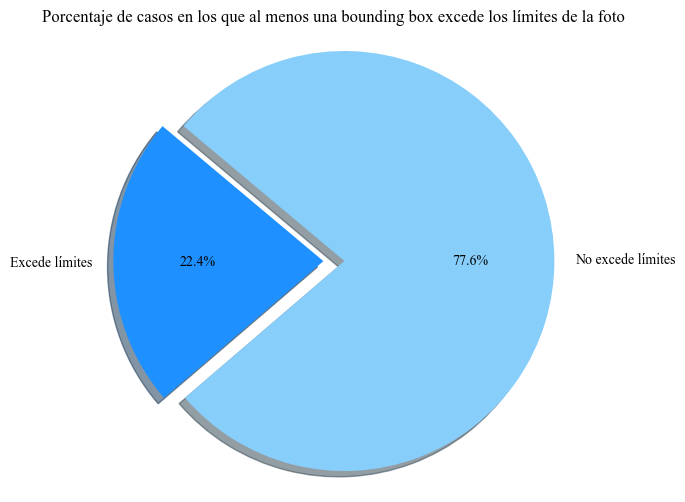

In [56]:
excede_limites = 0
total = 0

for item in data:
    total += 1
    annotations = item.get('annotations', [])
    width_img = item['item']['slots'][0]['width']
    height_img = item['item']['slots'][0]['height']
    excede = False
    for annotation in annotations:
        box_info = annotation.get('bounding_box', {})
        x, y, w, h = box_info.get('x', 0), box_info.get('y', 0), box_info.get('w', 0), box_info.get('h', 0)
        if x < 0 or y < 0 or x + w > width_img or y + h > height_img:
            excede = True
            break  
    if excede:
        excede_limites += 1

no_excede_limites = total - excede_limites

labels = ['Excede límites', 'No excede límites']
sizes = [excede_limites, no_excede_limites]
colors = ['dodgerblue', 'lightskyblue']
explode = (0.1, 0) 

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Porcentaje de casos en los que al menos una bounding box excede los límites de la foto')
plt.show()

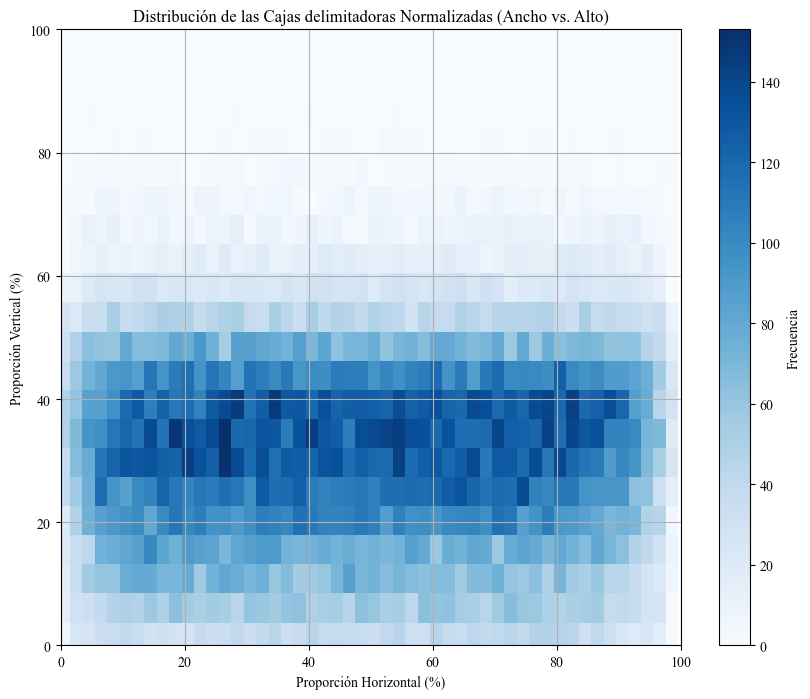

In [57]:
x_ratios = []
y_ratios = []
width_ratios = []
height_ratios = []

for item in data:
    image_width = item['item']['slots'][0]['width']
    image_height = item['item']['slots'][0]['height']
    annotations = item.get('annotations', [])
    for annotation in annotations:
        bounding_box = annotation.get('bounding_box', {})
        x_ratio = bounding_box.get('x', 0) / image_width * 100
        y_ratio = bounding_box.get('y', 0) / image_height * 100
        width_ratio = bounding_box.get('w', 0) / image_width * 100
        height_ratio = bounding_box.get('h', 0) / image_height * 100
        x_ratios.append(x_ratio)
        y_ratios.append(y_ratio)
        width_ratios.append(width_ratio)
        height_ratios.append(height_ratio)

plt.figure(figsize=(10, 8))
plt.hist2d(x_ratios, y_ratios, bins=50, cmap='Blues')
plt.colorbar(label='Frecuencia')
plt.title('Distribución de las Cajas delimitadoras Normalizadas (Ancho vs. Alto)')
plt.xlabel('Proporción Horizontal (%)')
plt.ylabel('Proporción Vertical (%)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

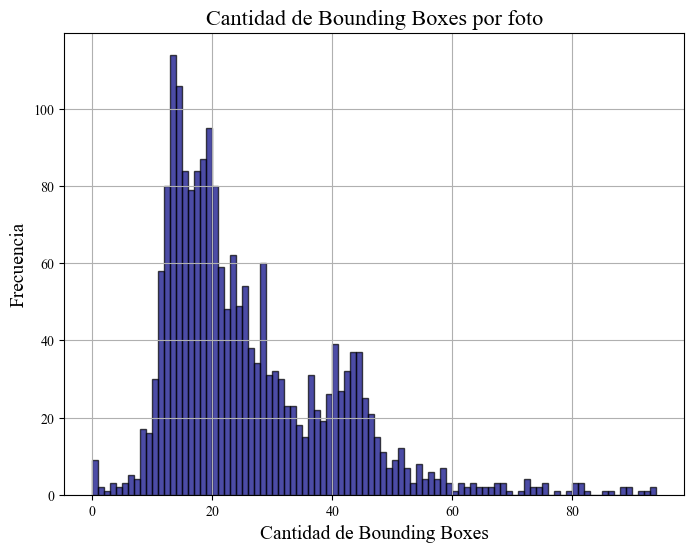

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(bounding_box_counts, bins=range(min(bounding_box_counts), max(bounding_box_counts) + 1), color='navy', edgecolor='black', alpha=0.7)
plt.title('Cantidad de Bounding Boxes por foto', fontsize=16)
plt.xlabel('Cantidad de Bounding Boxes', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True)
plt.show()

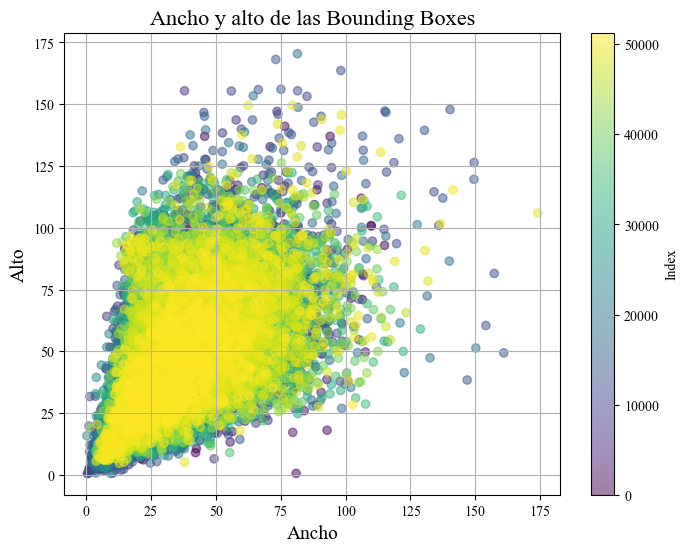

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(bounding_box_widths, bounding_box_heights, c=range(len(bounding_box_widths)), cmap='viridis', alpha=0.5)
plt.title('Ancho y alto de las Bounding Boxes', fontsize=16)
plt.xlabel('Ancho', fontsize=14)
plt.ylabel('Alto', fontsize=14)
plt.grid(True)
plt.colorbar(label='Index')
plt.show()

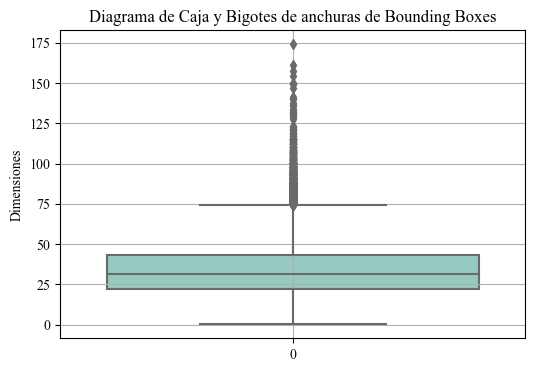

In [60]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=bounding_box_widths, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de anchuras de Bounding Boxes')
# plt.xticks([0, 1], ['Ancho', 'Alto'])
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

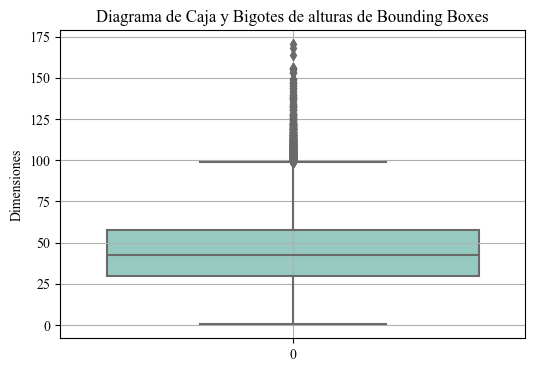

In [61]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=bounding_box_heights, palette='Set3')
plt.title('Diagrama de Caja y Bigotes de alturas de Bounding Boxes')
# plt.xticks([0, 1], ['Ancho', 'Alto'])
plt.ylabel('Dimensiones')
plt.grid(True)
plt.show()

In [62]:
folder_path = "./images"

image_names = []
mean_hue_list = []
mean_saturation_list = []
mean_brightness_list = []
red_list = []
green_list = []
blue_list = []
contrast_list = []
bluriness_list = []
area_list = []
entropy_list = []

In [85]:
for filename in os.listdir(folder_path):
    if filename.endswith((".png", ".jpg")):
        image_names.append(filename)
        
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        
        image_hsv = image.convert('HSV')
        
        hues = []
        saturations = []
        brightnesses = []
        for pixel in image_hsv.getdata():
            hues.append(pixel[0])
            saturations.append(pixel[1])
            brightnesses.append(pixel[2])
        mean_hue = np.mean(hues)
        mean_saturation = np.mean(saturations)
        mean_brightness = np.mean(brightnesses)
        
        mean_hue_list.append(mean_hue)
        mean_saturation_list.append(mean_saturation)
        mean_brightness_list.append(mean_brightness)
        
        img_rgb = np.array(image.convert('RGB'))
        red_mean = np.mean(img_rgb[:, :, 0])
        green_mean = np.mean(img_rgb[:, :, 1])
        blue_mean = np.mean(img_rgb[:, :, 2])
        
        gray_image = np.array(image.convert('L'))
        contrast = cv2.Laplacian(gray_image, cv2.CV_64F).var()

        blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        bluriness = cv2.Laplacian(blurred_image, cv2.CV_64F).var()
        
        
        area = img_rgb.shape[0] * img_rgb.shape[1]
        
        hist = cv2.calcHist([np.array(image.convert('L'))], [0], None, [256], [0, 256])
        hist = hist.ravel() / hist.sum()
        entropy = -np.sum(hist * np.log2(hist + 1e-8))
        
        red_list.append(red_mean)
        green_list.append(green_mean)
        blue_list.append(blue_mean)
        contrast_list.append(contrast)
        bluriness_list.append(bluriness)
        area_list.append(area)
        entropy_list.append(entropy)

In [64]:
layout_info = pd.read_csv("layoutsWithTags.csv")

In [65]:
data = {
    'image_name': image_names,
    'mean_hue': mean_hue_list,
    'mean_saturation': mean_saturation_list,
    'mean_brightness': mean_brightness_list,
    'red': red_list,
    'green': green_list,
    'blue': blue_list,
    'contrast': contrast_list,
    'bluriness': bluriness_list,
    'area': area_list,
    'entropy': entropy_list
}

In [70]:
df = pd.DataFrame(data)

df['layout_id'] = df['image_name'].apply(lambda x: int(x.split('_')[0]))

label_cluster_df = pd.read_csv('layoutsWithTags.csv')

df = pd.merge(df, label_cluster_df, on='layout_id', how='left')

In [75]:
correlation_matrix = df.drop(['layout_id', 'image_name', 'country', 'coincidencia', 'relevant (new) tags', 'trial_id', 'coincidencia'], axis=1).corr()

In [77]:
print(correlation_matrix.dtypes)

mean_hue           float64
mean_saturation    float64
mean_brightness    float64
red                float64
green              float64
blue               float64
contrast           float64
bluriness          float64
area               float64
entropy            float64
dtype: object


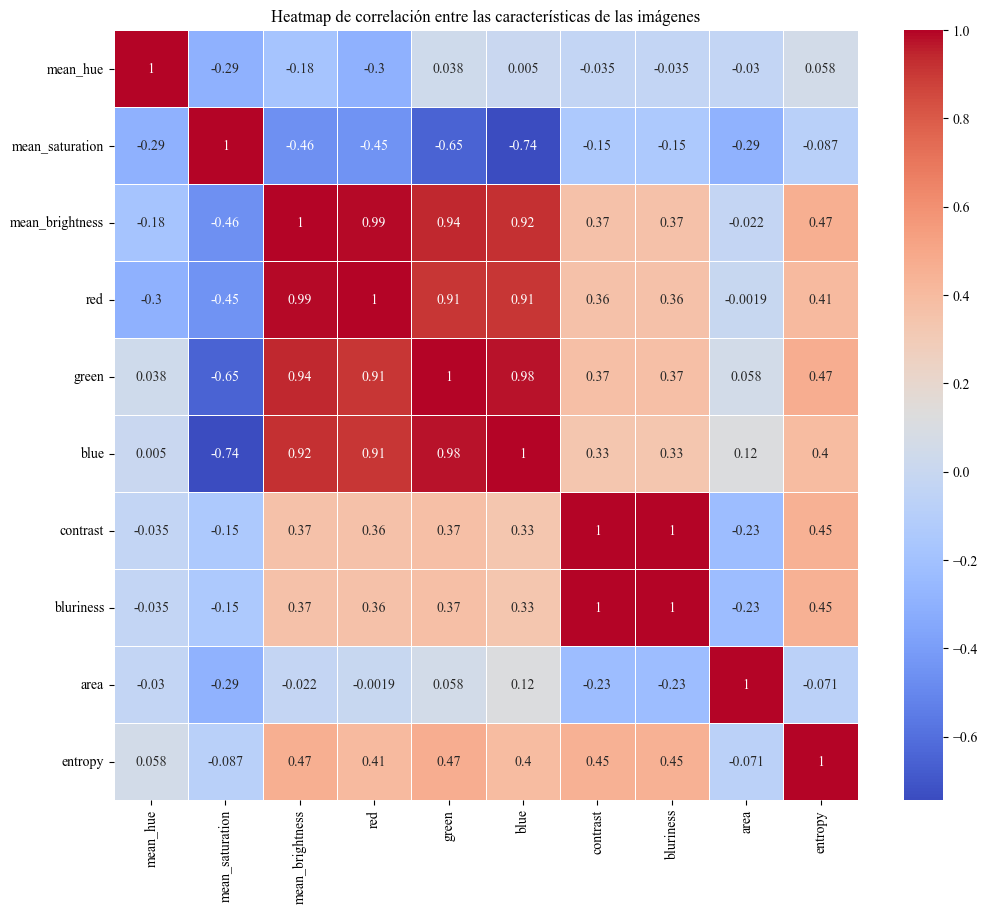

In [79]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de correlación entre las características de las imágenes')
plt.show()

In [80]:
df.to_csv('imageFeatures.csv', index=False)

print("Los valores de las características se han guardado en imageFeatures.csv")

Los valores de las características se han guardado en imageFeatures.csv


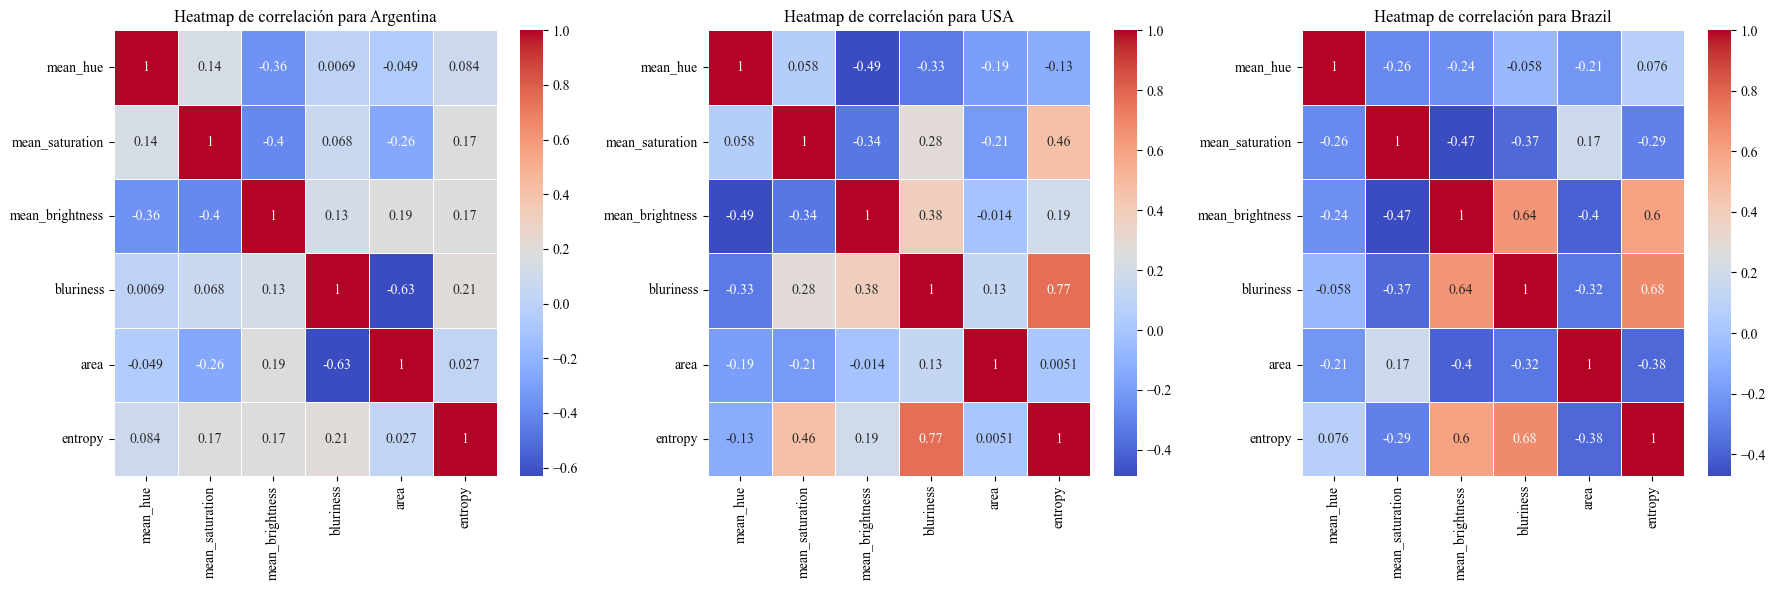

In [84]:
countries = df['country'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(countries), figsize=(18, 6))

for i, country in enumerate(countries):
    country_df = df[df['country'] == country]
    
    correlation_matrix_country = country_df.drop(['layout_id', 'image_name', 'country', 'red', 'green', 'blue', 'coincidencia', 'contrast', 'relevant (new) tags', 'trial_id'], axis=1).corr()
    
    sns.heatmap(correlation_matrix_country, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[i])
    axes[i].set_title(f'Heatmap de correlación para {country}')

plt.tight_layout()

plt.show()

In [ ]:
df.to_csv('imageFeatures.csv', index=False)

print("Los valores de las características se han guardado en imageFeatures.csv")

Los valores de las características se han guardado en imageFeatures.csv


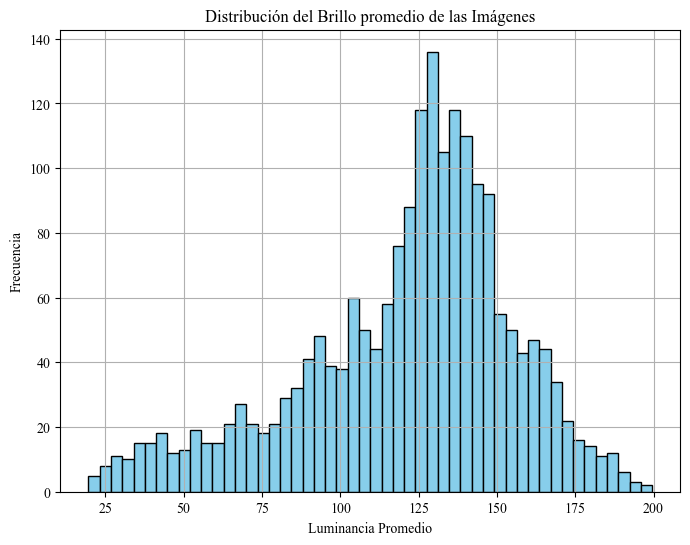

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(mean_brightness_list, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución del Brillo promedio de las Imágenes')
plt.xlabel('Luminancia Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Hue

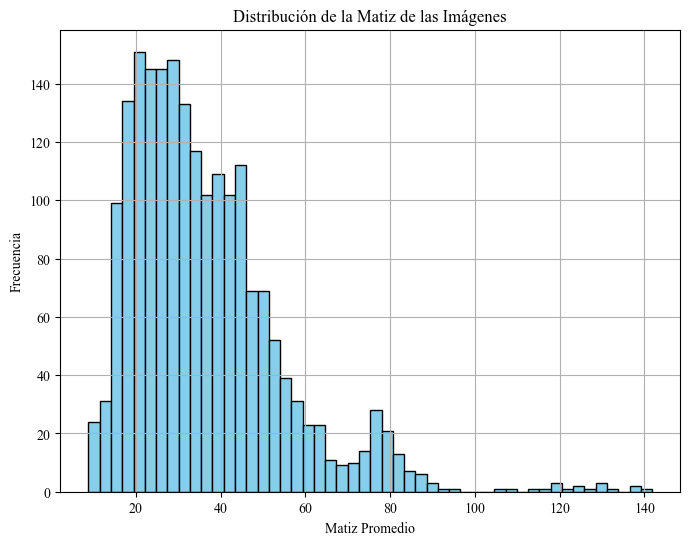

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(mean_hue_list, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de la Matiz de las Imágenes')
plt.xlabel('Matiz Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Saturacion

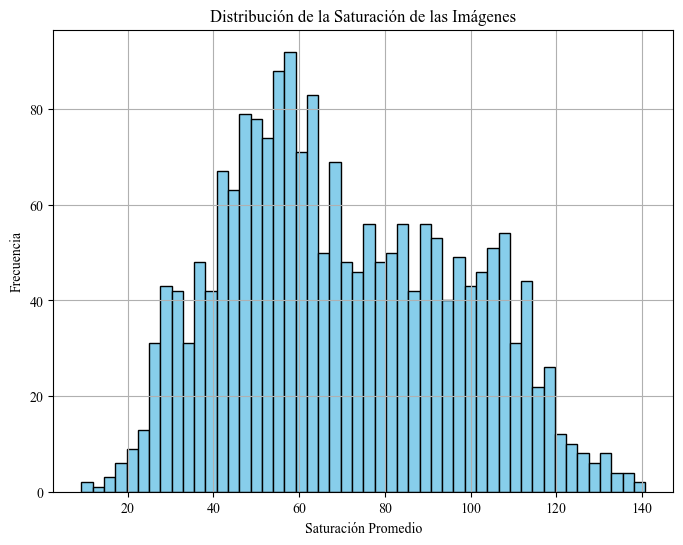

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(mean_saturation_list, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de la Saturación de las Imágenes')
plt.xlabel('Saturación Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

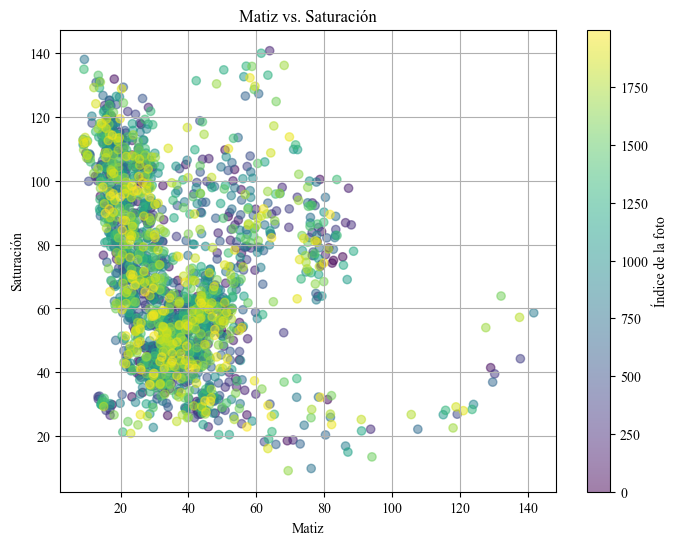

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(hue_values, saturation_values, c=range(len(saturation_values)), cmap='viridis', alpha=0.5)
plt.title('Matiz vs. Saturación')
plt.xlabel('Matiz')
plt.ylabel('Saturación')
plt.colorbar(label='Índice de la foto')  # Agregar la barra de colores para el índice de la foto
plt.grid(True)
plt.show()

# RGB

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

images_dir = "./images"
image_files = [f for f in os.listdir(images_dir) if f.endswith((".png", ".jpg"))]
num_images = len(image_files)
image_size = (100, 100)

rgb_values = []

for filename in image_files:
    image_path = os.path.join(images_dir, filename)
    img = Image.open(image_path)
    img = img.resize(image_size)
    img_rgb = np.array(img.convert('RGB'))
    for row in img_rgb:
        for pixel in row:
            rgb_values.append(pixel)

rgb_values = np.array(rgb_values)

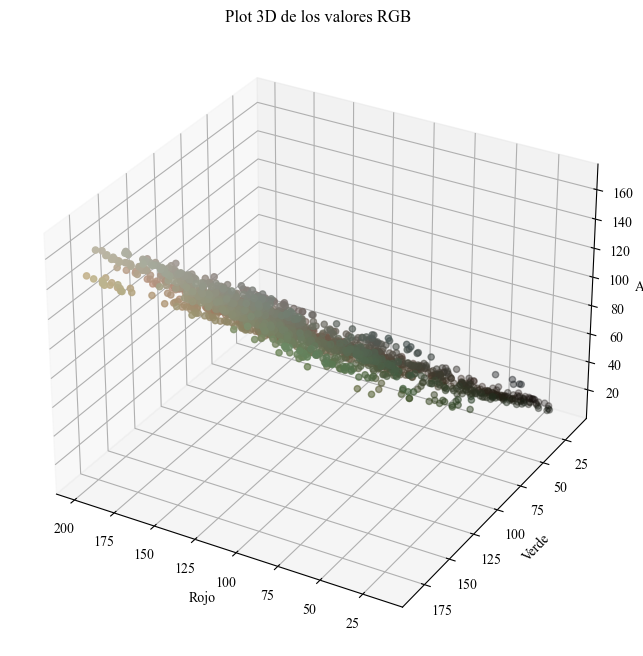

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['red'], df['green'], df['blue'], c=df[['red', 'green', 'blue']] / 255, marker='o')

ax.set_xlabel('Rojo')
ax.set_ylabel('Verde')
ax.set_zlabel('Azul')

plt.title('Plot 3D de los valores RGB')

ax.view_init(30, 120)

plt.show()

# Texture Analysis 

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


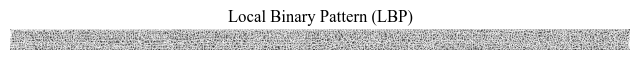

In [ ]:
images = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        images.append(image)

rgb_images = [rgba2rgb(np.array(image)) for image in images]

gray_images = [rgb2gray(image) for image in rgb_images]

radius = 3
n_points = 8 * radius

lbp_image = local_binary_pattern(gray_images[0], n_points, radius, method='uniform')

lbp_image = (lbp_image - np.min(lbp_image)) / (np.max(lbp_image) - np.min(lbp_image)) * 255

plt.figure(figsize=(8, 4))
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')
plt.axis('off')
plt.show()

Patrones LBP: Cada valor en la imagen representa un patrón LBP calculado para cada píxel de la imagen original. Los patrones LBP capturan la información sobre la textura local alrededor de cada píxel. Cada píxel en la imagen LBP se calcula comparando el valor del píxel central con los valores de los píxeles circundantes en una vecindad definida por el radio y el número de puntos.

Escala de grises: La imagen LBP se muestra en escala de grises, donde los valores más bajos corresponden a áreas con texturas más suaves o uniformes, mientras que los valores más altos representan áreas con texturas más variadas o complejas.

Rango de valores: Los valores en la imagen LBP están normalizados para que se ajusten al rango [0, 255], lo que permite una mejor visualización y comparación entre diferentes imágenes y diferentes partes de la misma imagen.

Interpretación: Las regiones más oscuras en la imagen LBP indican áreas con texturas más simples y uniformes, mientras que las regiones más claras indican áreas con texturas más complejas o variadas. Al observar la distribución de los valores LBP en la imagen, se pueden identificar diferentes tipos de texturas presentes en la imagen original.